In [4]:
%%capture
!pip install ultralytics
!pip install ensemble-boxes

## Imports

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import re
import matplotlib.patches as patches
import os
import yaml
import json
import shutil
import torch

from collections import Counter
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from ensemble_boxes import weighted_boxes_fusion
from ultralytics import YOLO
import wandb
import warnings
warnings.filterwarnings("ignore")

## connect to Weights and biases

In [4]:
try:
    api_key = "Enter your WandB API here"
    wandb.login(key=api_key)
except:
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. '
          'Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Configs

In [7]:
class Config:
    # Path
    base_dir = "../input/"
    
    train_imgs_dir = '/kaggle/input/dataset/train/train'
    test_imgs_dir = '/kaggle/input/dataset/test/test'
    # Model
    model_name = 'yolov8l.pt'
    img_res = 512
    
    # Training
    n_folds = 5
    selected_folds = [0, 1, 2, 3, 4]
    training_params = {
        "epochs": 30,
        "close_mosaic": 30,
        "batch": 64,
        "optimizer": "auto",
        "seed": 42,
        "device": [0, 1],
        "verbose": False,
        "resume": False,
        "patience": 20,
        "iou": 0.5,
        "fliplr": 0.0
    }


config = Config()

## Define utility functions for preprocessing


In [8]:
def get_class_counts(train_df):
    class_counts = {image_id: {i: 0 for i in range(1, config.num_classes+1)} for image_id in train_df["Image_ID"].unique()}
    for image_id in tqdm(train_df["Image_ID"].unique(), desc='Preparing for cross validation'):
        for target in range(1, config.num_classes):
            if len(train_df.loc[(train_df.Image_ID==image_id) & (train_df.ToothClass==int(target))]) > 0:
                class_counts[image_id][target] = 1

    return pd.DataFrame(class_counts).T.reset_index().rename(columns={"index": "Image_ID"})

In [9]:
def format_image_id(image_id, ext="png"):
    image_id = str(image_id)
    if "ID_" in image_id and "." in image_id:
        return image_id
    elif "." in image_id:
        return f"ID_{int(image_id):06d}"
    elif "ID_" in image_id:
        return f"{image_id}.{ext}"
    else:
        return f"ID_{int(image_id):06d}.{ext}"

In [10]:
def move_images(dest_dir, df):
    os.makedirs(dest_dir, exist_ok=True)
    unique_imgs = df.Image_ID.unique()
    for img in tqdm(unique_imgs, total=len(unique_imgs), desc="Moving images"):
        shutil.copy(os.path.join(config.train_imgs_dir, format_image_id(img)), dest_dir)

In [11]:
def decode_bbox(bbox: list):
    x_min, y_min, x_max, y_max = bbox
    xc = round((x_min + x_max) / 2)
    yc = round((y_min + y_max) / 2)
    w = x_max - x_min
    h = y_max - y_min
    box = np.array([xc, yc, w, h]) / config.img_res
    return " ".join(f"{i:.4g}" for i in box)

In [12]:
def create_labels(phase, df):
    phase = os.path.join(phase, "labels")
    os.makedirs(phase, exist_ok=True)
    unique_imgs = df.Image_ID.unique()
    for i, img in tqdm(enumerate(unique_imgs), total=len(unique_imgs), desc="Creating labels"):
        df_img = df.loc[df.Image_ID==img]
        boxes = [f'{row.ToothClass} {decode_bbox(row[["Xmin", "Ymin", "Xmax", "Ymax"]])}' for _, row in df_img.iterrows()]
        with open(os.path.join(phase, format_image_id(img, ext="txt")), "w") as f:
            for box in boxes:
                f.write(box + "\n")

In [13]:
def get_prediction(model, image_id, phase="val"):
    if phase == "val":
        path = config.train_imgs_dir
    else:
        path = config.test_imgs_dir
    pred = model.predict(os.path.join(path, format_image_id(image_id)), imgsz=config.img_res, conf=0.3, augment=False, agnostic_nms=False)
    pred = json.loads(pred[0].tojson())
    return pred

## Define Metrics

In [14]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    # Slicing idx:idx+1 in order to keep tensor dimensionality
    # Doing ... in indexing if there would be additional dimensions
    # Like for Yolo algorithm which would have (N, S, S, 4) in shape
    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Need clamp(0) in case they do not intersect, then we want intersection to be 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [15]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0.5, box_format="corners", num_classes=20
):
    """
    Calculates mean average precision 

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[2:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = TP_cumsum / (TP_cumsum + FP_cumsum + epsilon)
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / (len(average_precisions)+0.0000001)

## Define evaluation function


In [16]:
def evaluate_model(model, val_df):
    transformed_pred = []
    
    for image_id in tqdm(val_df["Image_ID"].unique(), desc="Evaluating"):
        pred = get_prediction(model, image_id)
        for item in pred:
            transformed_pred.append({
                'Image_ID': image_id,
                'ToothClass': item['class'],
                'confidence': item['confidence'],
                'Xmin': item['box']['x1'],
                'Ymin': item['box']['y1'],
                'Xmax': item['box']['x2'],
                'Ymax': item['box']['y2']
            })
    transformed_pred_ = [[v for v in pred.values()] for pred in transformed_pred]
    val_df_ = [row.values.tolist() for _, row in val_df.iterrows()]
    mAP = mean_average_precision(transformed_pred_, val_df_, num_classes=config.num_classes)
    transformed_pred = pd.DataFrame(transformed_pred)
    
    return mAP.item(), transformed_pred

## function to generate predicitons

In [17]:
def generate_prediction(model, ss):
    
    unique_imgs = ss["Image_ID"].unique()
    transformed_pred = []
    for image_id in tqdm(unique_imgs, total=len(unique_imgs), desc="Generaing predictions"):
        pred = get_prediction(model, image_id, phase="test")
        for item in pred:
            transformed_pred.append({
                'Image_ID': image_id,
                'ToothClass': int(item['name']),
                'confidence': item['confidence'],
                'Xmin': item['box']['x1'],
                'Ymin': item['box']['y1'],
                'Xmax': item['box']['x2'],
                'Ymax': item['box']['y2']
            })
    transformed_pred = pd.DataFrame(transformed_pred)
    return transformed_pred

## Load the data and create dataloaders


In [20]:
train = pd.read_csv('//kaggle/input/dataset/Train.csv')
ss = pd.read_csv('/kaggle/input/dataset/SampleSubmission.csv')

# config.actual_classes = train.ToothClass.unique().tolist()
config.classes = train.ToothClass.unique().tolist()
config.num_classes = len(config.classes)
config.id2cls = {k:v for k, v in enumerate(config.classes)}
config.cls2id = {v:k for k, v in enumerate(config.classes)}

train["ToothClass"] = train["ToothClass"].map(config.cls2id)

class_counts = get_class_counts(train)

def get_new_labels(y):
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y.values])
    return y_new

y_new = get_new_labels(class_counts[range(1, config.num_classes+1)])

folds = StratifiedKFold(n_splits=config.n_folds, shuffle=True, random_state=config.training_params["seed"])
class_counts['fold'] = -1
for i, (train_index, test_index) in enumerate(folds.split(class_counts, y=y_new)):
    class_counts.loc[test_index,'fold'] = i

with open("data.yaml", "w") as f:
    json.dump({"train": "train", "val": "val", "nc": config.num_classes, "names": config.classes}, f)

cv_scores = []
preds = []
for fold in range(config.n_folds):
    if fold not in config.selected_folds:
        continue
    print(f'--------------------------------Training Fold {fold+1}/5---------------------------------')
    train_ids = class_counts[class_counts.fold!=fold].reset_index(drop=True)
    valid_ids = class_counts[class_counts.fold==fold].reset_index(drop=True)

    train_ = train.loc[train.Image_ID.isin(train_ids.Image_ID.values)]
    val_ = train.loc[train.Image_ID.isin(valid_ids.Image_ID.values)]

    print(f"Training Data: {len(train_)} - unique: {train_.Image_ID.nunique()}")
    print(f"Validating Data: {len(val_)} - unique: {val_.Image_ID.nunique()}")

    train_dir = os.path.join("train", "images")
    val_dir = os.path.join("val", "images")
    move_images(train_dir, train_)
    move_images(val_dir, val_)

    create_labels("train", train_)
    create_labels("val", val_)

    model = YOLO(config.model_name)
    model.train(data="/kaggle/working/data.yaml", task="detect", imgsz=config.img_res, val=True,
                name=f"Yolo_M_fold_{fold}", **config.training_params)
    score, preds_df = evaluate_model(model, val_)
    cv_scores.append(score)
    preds.append(generate_prediction(model, ss))
    preds[-1].to_csv(f"preds_fold_{fold}.csv", index=False)
    # Remove directories
    shutil.rmtree("train")
    shutil.rmtree("val")
    print(f"Score on fold {fold}: {score}")

print(f"cv score: {np.mean(cv_scores)}")

Preparing for cross validation: 100%|██████████| 1200/1200 [00:22<00:00, 53.93it/s]


--------------------------------Training Fold 1/5---------------------------------
Training Data: 12813 - unique: 960
Validating Data: 3200 - unique: 240


Creating labels: 100%|██████████| 240/240 [00:01<00:00, 130.70it/s]


100%|██████████| 83.7M/83.7M [00:00<00:00, 225MB/s] 


Ultralytics YOLOv8.2.21 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15102MiB)
                                                      CUDA:1 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/kaggle/working/data.yaml, epochs=30, time=None, patience=20, batch=64, imgsz=512, save=True, save_period=-1, cache=False, device=[0, 1], workers=8, project=None, name=Yolo_M_fold_0, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=30, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.5, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, sav

100%|██████████| 755k/755k [00:00<00:00, 13.6MB/s]
2024-05-24 17:12:28,980	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-05-24 17:12:29,799	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=32

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           
  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytic

wandb: ERROR api_key not configured (no-tty). call wandb.login(key=[your_api_key])
Traceback (most recent call last):
  File "/root/.config/Ultralytics/DDP/_temp_36j6v5un139384761204640.py", line 12, in <module>
    results = trainer.train()
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 199, in train
    self._do_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 313, in _do_train
    self._setup_train(world_size)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 226, in _setup_train
    self.run_callbacks("on_pretrain_routine_start")
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/engine/trainer.py", line 162, in run_callbacks
    callback(self)
  File "/opt/conda/lib/python3.10/site-packages/ultralytics/utils/callbacks/wb.py", line 112, in on_pretrain_routine_start
    wb.run or wb.init(project=trainer.args.project or "YOLOv8", name=trainer.args.na

CalledProcessError: Command '['/opt/conda/bin/python3.10', '-m', 'torch.distributed.run', '--nproc_per_node', '2', '--master_port', '58821', '/root/.config/Ultralytics/DDP/_temp_36j6v5un139384761204640.py']' returned non-zero exit status 1.

## apply ensemble methods

In [23]:
def prepare_ensemble_data(dfs, image_id):
    boxes_list = []
    scores_list = []
    labels_list = []

    
    for df in dfs:
        filtered_df = df[df['Image_ID'] == image_id]
        boxes = filtered_df[['Xmin', 'Ymin', 'Xmax', 'Ymax']].values.tolist()
        scores = filtered_df['confidence'].values.tolist()
        labels = filtered_df['ToothClass'].map(config.cls2id).astype('category').values.tolist()
        
        boxes_list.append(boxes)
        scores_list.append(scores)
        labels_list.append(labels)
    
    return boxes_list, scores_list, labels_list

### function Applies Weighted_boxes_fusion (WBF)

In [24]:
def ensemble_predictions(preds, ss):
    fused_predictions = []
    for image_id in ss.Image_ID.unique():
        boxes_list, scores_list, labels_list = prepare_ensemble_data(preds, image_id)
        # Normalize the boxes to [0, 1] scale as required by WBF
        boxes_list = [[(np.array(box) / config.img_res).tolist() for box in boxes] for boxes in boxes_list]
        boxes, scores, labels = weighted_boxes_fusion(boxes_list, scores_list, labels_list, iou_thr=0.5, skip_box_thr=0.0)
        # Denormalize the boxes back to original scale
        boxes = [(np.array(box) * config.img_res).tolist() for box in boxes]
        result_df = pd.DataFrame(boxes, columns=['Xmin', 'Ymin', 'Xmax', 'Ymax'])
        result_df['confidence'] = scores
        categories = map(lambda t: t[0], sorted(config.cls2id.items(), key=lambda t:t[1]))
        result_df['ToothClass'] = pd.Categorical.from_codes(labels.astype(int), categories=categories)
        result_df['Image_ID'] = image_id
        fused_predictions.append(result_df[["Image_ID", "ToothClass", "confidence", "Xmin", "Ymin", "Xmax", "Ymax"]])
    return pd.concat(fused_predictions, axis=0)

In [25]:
pred = ensemble_predictions(preds, ss)
pred["ToothClass"] = "class_" + pred["ToothClass"].astype(str)
pred.columns = ["Image_ID", "class", "confidence", "xmin", "ymin", "xmax", "ymax"]

In [ ]:
%%capture --no-display
pred.to_csv("Submission_ensemble.csv", index=False)
pred.head(20)

In [ ]:
%%capture --no-display
pred = preds[3]
pred["ToothClass"] = "class_" + pred["ToothClass"].astype(str)
pred.columns = ["Image_ID", "class", "confidence", "xmin", "ymin", "xmax", "ymax"]
pred.to_csv("Submission_without_ensemble_fold_4.csv", index=False)
pred.head(20)

## post-processnig

In [29]:
train1 = pd.read_csv('/kaggle/input/dataset/Train.csv')
test1 = pd.read_csv('/kaggle/input/dataset/Test.csv')

target_cols = ['ToothClass', 'Xmin', 'Ymin', 'Xmax', 'Ymax']
target_col = ['upper','lower']
# CFG.target_col = target_col

NameError: name 'CFG' is not defined

## Post-Processing

In [31]:
def create_file_name(x):
    
    ch = 'ID_'+str(x)+'.png'
    while (len(ch)<len('ID_000000.png')):
        ch = ch[:3]+'0'+ch[3:]
        
    return ch

train1['filename']=train1['Image_ID'].map(create_file_name )
test1['filename']=test1['Image_ID'].map(lambda x : x+'.png')

In [57]:
sub = pd.read_csv('/kaggle/working/Submission_ensemble.csv') # the path for your submission
sub['is_upper']=sub['Image_ID'].map(lambda x :int(int(x[4:])>1499) )
sub['box']=sub.apply(lambda row: [row['xmin'], row['ymin'], row['xmax'], row['ymax']], axis=1)
train1['box'] = train1.apply(lambda row: [row['Xmin'], row['Ymin'], row['Xmax'], row['Ymax']], axis=1)
# test['Image_ID'] = test['Image_ID'].map(lambda x : int(x[3:]))
sub['Image_ID'] = sub['Image_ID'].map(lambda x : int(x[3:]))

sub1 = sub.copy()
sub1['Xmin'] = sub1['xmin']
sub1['Ymin'] = sub1['ymin']
sub1['Xmax'] = sub1['xmax']
sub1['Ymax'] = sub1['ymax']
sub1['ToothClass']=sub1['class']

## function to draw labels for the train/test dataset

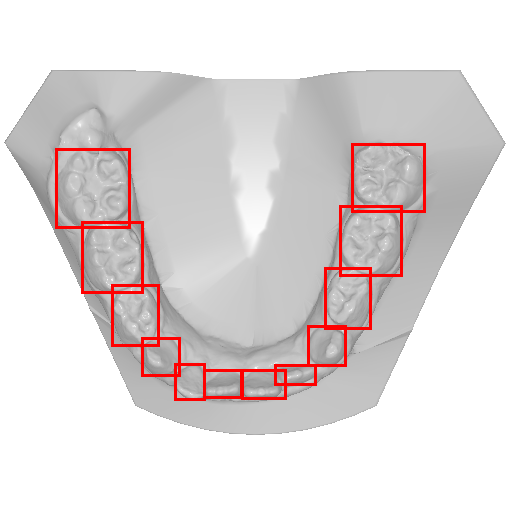

In [51]:
from PIL import Image, ImageDraw
import IPython.display as display

def draw_rectangles_and_labels(df,file_name):
    
    image_path = '/kaggle/input/dataset/train/train/' + file_name
    n = int(file_name[3:-4])
    df = train1[train1['Image_ID'] == n]
    
    # Open the image
    image = Image.open(image_path)
    
    # Iterate over the DataFrame and draw rectangles
    for i, box in enumerate(df['box']):
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        draw = ImageDraw.Draw(image)
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)

    # Display the image inline in a Jupyter notebook
    display.display(image)
    
    # Clear the content of the image
    image = None  # This will delete the image object from memory

# Example usage
draw_rectangles_and_labels('train','ID_000020.png')

### function to draw bounding boxes and labels for the predictions

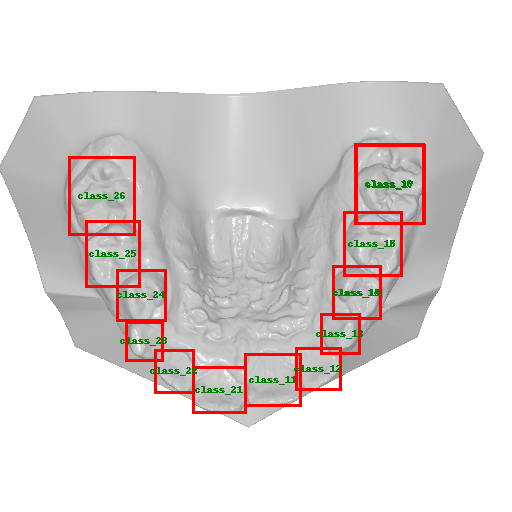

In [97]:
from PIL import Image, ImageDraw, ImageFont
def draw_predictions(file_name):
    image_path = '/kaggle/input/dataset/test/test/' + file_name
    n = int(file_name[3:-4])
    df = sub1[sub1['Image_ID'] == n]
    
    # Open the image
    image = Image.open(image_path)
    
    # Create a drawing context
    draw = ImageDraw.Draw(image)
    
    # Load a font
    try:
        font = ImageFont.truetype("arial.ttf", 20)
    except IOError:
        font = ImageFont.load_default()

    # Iterate over the DataFrame and draw rectangles and text
    for i, row in df.iterrows():
        box = row['box']
        class_id = row['class']
        
        xmin, ymin, xmax, ymax = box[0], box[1], box[2], box[3]
        draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)
        
        # Calculate the center of the box
        text_x = (xmin + xmax) / 2
        text_y = (ymin + ymax) / 2
        
        # Get the size of the text to be drawn
        text = str(class_id)
        text_size = draw.textsize(text, font=font)
        
        # Calculate the position for the text
        text_position = (text_x - text_size[0] / 2, text_y - text_size[1] / 2)
        
        # Draw the text
        draw.text(text_position, text, fill="green", font=font)
    
    # Display the image inline in a Jupyter notebook
    display.display(image)
    
    # Clear the content of the image
    image = None  # This wil
draw_predictions('ID_001501.png')

### Postprossing

### define lower and upper jaw dataframes 

In [63]:
# post-processing : check for upper / lower missmatch
up = ["1" , "2"]
lower = ["3" , "4"]

# upper df 
upper_df = sub[sub['is_upper']==1]
# lower df 
lower_df = sub[sub['is_upper']==0]

# Verify if the images of the lower and upper jaw have the correct labels

In [98]:
# verify the labels 
lower_df['class'].unique() # labels miss-match for the lower part

array(['class_35', 'class_46', 'class_36', 'class_34', 'class_45', 'class_33', 'class_44', 'class_43', 'class_37', 'class_47', 'class_41', 'class_42', 'class_32', 'class_31', 'class_38', 'class_48', 'class_12', 'class_11', 'class_15', 'class_14', 'class_17', 'class_16', 'class_28', 'class_18', 'class_23', 'class_13'],
      dtype=object)

In [106]:
lower_df[lower_df['class']=='class_17']

,Image_ID,class,confidence,xmin,ymin,xmax,ymax,is_upper,box
3463,1437,class_17,0.071792,243.29482,101.35395,318.44141,178.83142,0,"[243.29482, 101.35395, 318.44141, 178.83142]"


## function to correct the labels 

In [99]:
lower_classes =['class_12', 'class_11', 'class_15', 'class_14', 'class_17', 'class_16', 'class_28', 'class_18', 'class_23', 'class_13']

lower_correct_classes ={'class_12':'class_32', 'class_11':'class_31', 'class_15':'class_35', 'class_14':'class_34', 'class_17':'class_37',
                        'class_16':'class_36', 'class_28':'class_48', 'class_18':'class_38', 'class_23':'class_43', 'class_13':'class_33'}
def correction_function(x):
    if x in lower_classes : 
        return lower_correct_classes[x]
    else : return x
lower_df1 = lower_df.copy()
lower_df1['class'] = lower_df1['class'].apply(correction_function)
corrected_sub = pd.concat([ lower_df1,upper_df ],axis=0)

In [100]:
corrected_sub=corrected_sub[['Image_ID', 'class', 'confidence', 'xmin', 'ymin', 'xmax', 'ymax']]
corrected_sub['Image_ID']=corrected_sub['Image_ID'].apply(lambda x :'ID_00'+str(x) )

In [101]:
corrected_sub.to_csv('submission_dridi.csv',index=False)

In [116]:
df = lower_df[lower_df['class']=='class_12']
# determine list of ids
ids = df['Image_ID'].unique()
for i in ids : 
    corrected_sub[corrected_sub['Image_ID']=='ID_00'+str(i)]
    

### define funciton to remove the duplicates bbox and labels , keeping only the label with the high confidence

In [118]:
def keep_max_confidence(df):
    return df.loc[df.groupby(['Image_ID', 'class'])['confidence'].idxmax()]

# Apply the function to corrected_sub
corrected_sub_unique = keep_max_confidence(corrected_sub)

In [109]:
# the number of predicted labels in the image with ID 001437 before eliminating Duplicate labels : 38
corrected_sub[corrected_sub['Image_ID']=='ID_001437']

,Image_ID,class,confidence,xmin,ymin,xmax,ymax
3424,ID_001437,class_33,0.787538,405.263855,252.078094,457.095703,295.737823
3425,ID_001437,class_44,0.778786,286.983490,368.797882,333.989532,423.053772
3426,ID_001437,class_47,0.768362,92.575531,344.922668,166.736557,418.053680
3427,ID_001437,class_41,0.679696,394.369690,364.698181,447.086395,409.182037
3428,ID_001437,class_34,0.663702,389.288025,218.736359,435.039795,261.587250
3429,ID_001437,class_43,0.602074,362.586823,376.364075,411.313507,424.344177
3430,ID_001437,class_44,0.588384,324.511444,390.043518,369.755096,438.246735
3431,ID_001437,class_35,0.537778,348.565948,192.760117,401.954681,243.494156
3432,ID_001437,class_42,0.530610,362.644775,376.463104,411.353882,424.435303
3433,ID_001437,class_37,0.513686,186.735275,69.517235,261.090851,145.477997


In [121]:
## the number of labels in the image with ID 001437 after eliminating duplicate labels :15
corrected_sub_unique[corrected_sub_unique['Image_ID']=='ID_001437']

,Image_ID,class,confidence,xmin,ymin,xmax,ymax
3434,ID_001437,class_31,0.484224,412.899200,352.760193,466.042267,391.274597
3435,ID_001437,class_32,0.466070,415.226593,289.876678,470.186676,329.249512
3424,ID_001437,class_33,0.787538,405.263855,252.078094,457.095703,295.737823
3428,ID_001437,class_34,0.663702,389.288025,218.736359,435.039795,261.587250
3431,ID_001437,class_35,0.537778,348.565948,192.760117,401.954681,243.494156
3439,ID_001437,class_36,0.416612,295.814941,147.059402,368.967651,218.996826
3433,ID_001437,class_37,0.513686,186.735275,69.517235,261.090851,145.477997
3427,ID_001437,class_41,0.679696,394.369690,364.698181,447.086395,409.182037
3432,ID_001437,class_42,0.530610,362.644775,376.463104,411.353882,424.435303
3429,ID_001437,class_43,0.602074,362.586823,376.364075,411.313507,424.344177


### shape before eliminating duplicates

In [111]:
corrected_sub.shape

(8549, 7)

### length after eliminating duplicates

In [122]:
len(corrected_sub_unique)

8116

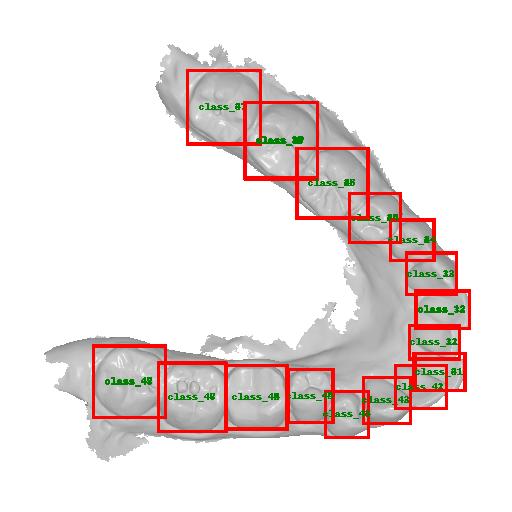

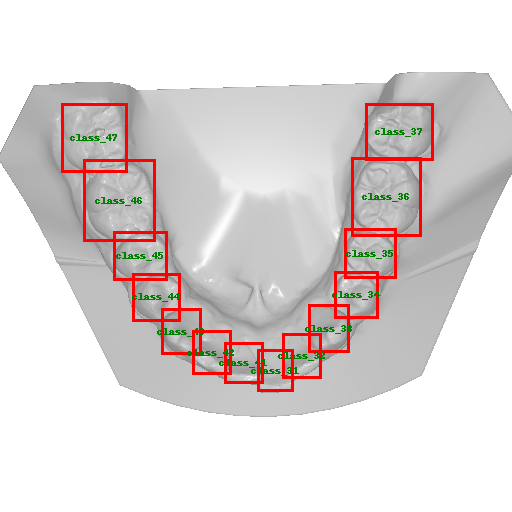

In [108]:
draw_predictions('ID_001437.png')
draw_predictions('ID_001200.png')

In [123]:
corrected_sub_unique.to_csv('unique.csv',index = False)